In [ ]:
# default_exp funcs.train_funcs

In [ ]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

# Training loop simulator learning

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.plotting import *
from decode_fish.funcs.predict import *
from decode_fish.funcs.visualization import *
import torch.nn.functional as F
from torch import distributions as D
from torch.utils.data import DataLoader
import torch_optimizer
from decode_fish.engine.microscope import Microscope, get_roi_filt_inds, extract_psf_roi, mic_inp_apply_inds, add_pos_noise
from decode_fish.engine.model import UnetDecodeNoBn
from decode_fish.engine.point_process import PointProcessUniform, get_phased_ints
from decode_fish.engine.gmm_loss import PointProcessGaussian
import shutil
import wandb
import kornia

from hydra import compose, initialize
from decode_fish.funcs.merfish_eval import *
from decode_fish.funcs.exp_specific import *
# from decode_fish.funcs.visualization vimport get_simulation_statistics

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [ ]:
#export
def eval_logger(pred_df, target_df, iteration, data_str='Sim. '):
    
    perf_dict,matches,shift = matching(target_df, pred_df, print_res=False,  match_genes=True)
    if 'Inp' in data_str:
        pred_corr = shift_df(pred_df, shift)
        perf_dict, _, _ = matching(target_df, pred_corr, print_res=False,  match_genes=True)

    wandb.log({data_str +'Metrics/eff_3d': perf_dict['eff_3d']}, step=iteration)
    wandb.log({data_str +'Metrics/jaccard': perf_dict['jaccard']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_vol': perf_dict['rmse_vol']}, step=iteration)

    wandb.log({data_str +'Metrics/precision': perf_dict['precision']}, step=iteration)
    wandb.log({data_str +'Metrics/recall': perf_dict['recall']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_x': perf_dict['rmse_x']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_y': perf_dict['rmse_y']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_z': perf_dict['rmse_z']}, step=iteration)   
    
    return matches

def save_train_state(save_dir, model, microscope, optim_dict, train_iter):
    
        torch.save({'state_dict':model.state_dict(), 'scaling':[model.inp_scale, model.inp_offset]}, save_dir/'model.pkl')
        torch.save(microscope.state_dict(), save_dir/'microscope.pkl')
        
        save_dict = {k:v.state_dict() for (k,v) in optim_dict.items()}
        save_dict['train_iter'] = train_iter
        
        torch.save(save_dict, save_dir/'training_state.pkl')
        
def exp_train_eval(bench_df, res_df, targets, wandb, batch_idx):
    
    if len(res_df):
    
        res_sub = res_df.nsmallest(len(bench_df), 'int_ratio')

        bench_counts = DF(data=None, index=targets)
        bench_counts['Res_all'] = res_sub.groupby('gene')['gene'].count()
        bench_counts['Bench_all'] = bench_df.groupby('gene')['gene'].count()
        bench_counts = bench_counts.fillna(0)
        
        r = np.corrcoef(bench_counts['Bench_all'].values, bench_counts['Res_all'].values)[0, 1]   

        blinds = []
        for i,g in enumerate(targets):
            if 'Blank' in g:
                blinds.append(g)

        bc = bench_counts.loc[blinds,'Res_all'].values.sum()
        bench_bc = bench_counts.loc[blinds,'Bench_all'].values.sum()
        
        bench_df['z'] = bench_df['z']/1000
        res_sub['z'] = res_sub['z']/100
        
        wandb.log({'AE Losses/code_bench_corr': r}, step=batch_idx)
        wandb.log({'AE Losses/N_blanks': bc/bench_bc}, step=batch_idx)
        
        perf_dict, match_df, shifts = matching(bench_df,  res_sub, tolerance=500)
        wandb.log({'AE Losses/jaccard': perf_dict['jaccard']}, step=batch_idx)        
        
    wandb.log({'AE Losses/N_pred_tot': len(res_df)/len(bench_df)}, step=batch_idx)

In [ ]:
#export 
def train(cfg,
          model, 
          microscope,
          post_proc,
          dl, 
          optim_dict):
    
    """
    Training loop for autoencoder learning. Alternates between a simulator training step to train the inference network
    and an autoencoder step to train the PSF (and microscope) parameters.
    
    Args:
        model (torch.nn.Module): DECODE 3D UNet.
        microscope (torch.nn.Module): Microscope class that transforms emitter locations into simulated images.
        post_proc (torch.nn.Module): Post processing class that transforms emitter probilities deterministically into binary outputs.
        dl  (torch.utils.data.dataloader.DataLoader): Dataloader that returns a random sub volume from the real volume, an estiamted emitter density and background.
        optim_dict (dict of torch.optim.Optimizer and torch.optim.lr_scheduler): Dict. with optimizer and scheduler objects for the network and gen. model parameters.
        
    """ 
    
    save_dir = Path(cfg.output.save_dir)
    bench_df = None

    model.cuda().train()
    
    # Save initial psf state
    torch.save(microscope.psf.state_dict(), str(save_dir) + '/psf_init.pkl' )
    
    # Load codebook 
    if 'codebook' in cfg:
        codebook, targets = hydra.utils.instantiate(cfg.codebook)
    
    # Controls which genmodel parameters are optimized
    for name, p in microscope.named_parameters():
        p.requires_grad = cfg.training.mic.par_grads[name]
        
    calc_log_p_x = False
    col_shift_map = cfg.genm.microscope.col_shifts_enabled
    
    # Hacky way to switch between network / genmodel training
    if cfg.training.schedule is not None:
        sched = cfg.training.schedule
        cfg.training.net.enabled = True
        cfg.training.mic.enabled = False
#         cfg.training.int.enabled = False
        switch_iter = sched.pop(0)
    
    for batch_idx in range(cfg.training.start_iter, cfg.training.num_iters+1):
        
        if cfg.training.schedule is not None:
            if batch_idx == switch_iter:
                cfg.training.net.enabled = not(cfg.training.net.enabled)
                cfg.training.mic.enabled = not(cfg.training.mic.enabled)
#                 cfg.training.int.enabled = not(cfg.training.int.enabled)
                switch_iter += sched.pop(0)

        t0 = time.time()
        ret_dict = next(iter(dl))
        # Get real data window and rate/background for the simulation
        x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'] 
        
        if col_shift_map:
            zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
            zcrop, ycrop, xcrop = zcrop.flatten(), ycrop.flatten(), xcrop.flatten()
            colshift_crop = get_color_shift_inp(microscope.color_shifts, microscope.col_shifts_yx, ycrop, xcrop, cfg.sim.random_crop.crop_sz)
        else:
            zcrop, ycrop, xcrop, colshift_crop = None, None, None, None
        
        background = background * microscope.get_ch_mult().detach()
        x = x * microscope.get_ch_mult().detach()
        

        if cfg.training.net.enabled:
    
            optim_dict['optim_net'].zero_grad()

            sim_vars = PointProcessUniform(local_rate[:,0], int_conc=model.int_dist.int_conc.detach(), 
                                           int_rate=model.int_dist.int_rate.detach(), int_loc=model.int_dist.int_loc.detach(), 
                                           sim_iters=5, channels=cfg.genm.exp_type.n_channels, n_bits=cfg.genm.exp_type.n_bits, 
                                           sim_z=cfg.genm.exp_type.pred_z, codebook=torch.tensor(codebook, dtype=torch.bool), int_option=cfg.training.int_option).sample(from_code_book=True)

            # sim_vars = locs_sl, x_os_sl, y_os_sl, z_os_sl, ints_sl, output_shape, codes
#             print('Sim, ', time.time()-t0); t0 = time.time()
            ch_inp = list(microscope.get_single_ch_inputs(*sim_vars[:-1], ycrop=ycrop, xcrop=xcrop))
            ch_inp[1:4] = add_pos_noise(ch_inp[1:4], [cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_z], cfg.genm.exp_type.n_bits)
            xsim = microscope(*ch_inp, add_noise=True)
            
            if cfg.genm.phasing:
                
                phasing_inp = list(microscope.get_single_ch_inputs(*sim_vars[:4], get_phased_ints(sim_vars[4], microscope.ch_cols, microscope.psf.n_cols) ,sim_vars[5], ycrop=ycrop, xcrop=xcrop))
                phasing_inp[1:4] = add_pos_noise(phasing_inp[1:4], [cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_z], cfg.genm.exp_type.n_bits, rm_mean=False)
                xsim += microscope(*phasing_inp, add_noise=True) * cfg.genm.phasing * torch.rand(xsim.shape, device=xsim.device)
#             print('Micro, ', time.time()-t0); t0 = time.time()

            # Spurious emitter patterns (not from codebook)
            if cfg.genm.emitter_noise.rate_fac:

                noise_vars = PointProcessUniform(local_rate[:,0] * cfg.genm.emitter_noise.rate_fac, int_conc=model.int_dist.int_conc.detach() * cfg.genm.emitter_noise.int_fac, 
                                               int_rate=model.int_dist.int_rate.detach(), int_loc=model.int_dist.int_loc.detach(), 
                                               sim_iters=5, channels=cfg.genm.exp_type.n_channels, n_bits=1, 
                                               sim_z=cfg.genm.exp_type.pred_z, codebook=None, int_option=cfg.training.int_option).sample(from_code_book=False)     

                noise_inp = microscope.get_single_ch_inputs(*noise_vars[:-1], ycrop=ycrop, xcrop=xcrop)
                xsim += microscope(*noise_inp, add_noise=True)

            xsim_noise = microscope.noise(xsim, background, const_theta_sim=cfg.genm.exp_type.const_theta_sim).sample()
            

#             print('Noise. ', time.time()-t0); t0 = time.time()
            
            net_inp = torch.concat([xsim_noise,colshift_crop], 1) if colshift_crop is not None else xsim_noise
            out_sim = model.tensor_to_dict(model(net_inp))
            
#             print('Model forw. ', time.time()-t0); t0 = time.time()

            ppg = PointProcessGaussian(**out_sim)

            count_prob, spatial_prob = ppg.log_prob(*sim_vars[:5], codes=sim_vars[-1], 
                                                    n_bits=cfg.genm.exp_type.n_bits, channels=cfg.genm.exp_type.n_channels, 
                                                    loss_option=cfg.training.loss_option, 
                                                    count_mult=cfg.training.count_mult, cat_logits=cfg.training.cat_logits,
                                                    slice_rec=cfg.genm.exp_type.slice_rec, z_sig_fac=cfg.training.z_sig_fac,
                                                    int_inf=cfg.genm.exp_type.int_inf)

            gmm_loss = -(spatial_prob + cfg.training.net.cnt_loss_scale*count_prob).mean()

            background_loss = F.mse_loss(out_sim['background'], background) * cfg.training.net.bl_loss_scale

            loss = gmm_loss + background_loss
            
#             print('Loss calc. ', time.time()-t0); t0 = time.time()

            # Update network parameters
            loss.backward()

            if cfg.training.net.grad_clip: torch.nn.utils.clip_grad_norm_(model.network.parameters(), max_norm=cfg.training.net.grad_clip, norm_type=2)

            optim_dict['optim_net'].step()
            optim_dict['sched_net'].step()

#             print('Grad upd. ', time.time()-t0); t0 = time.time()

        ch_out_inp = [[],[]]    
        if batch_idx > min(cfg.training.start_mic,cfg.training.start_int) and batch_idx % cfg.training.mic.freq == 0:
            
#             out_inp = model.tensor_to_dict(model(x))
            net_inp = torch.concat([x,colshift_crop], 1) if colshift_crop is not None else x
            out_inp = model.tensor_to_dict(model(net_inp))
            proc_out_inp = post_proc.get_micro_inp(out_inp)

            if cfg.training.mic.enabled and batch_idx > cfg.training.start_mic and len(proc_out_inp[1]) > 0: # and len(proc_out_inp[1]) < 300:
#                 print('Pre filt ', len(proc_out_inp[1]))
                ch_out_inp = microscope.get_single_ch_inputs(*proc_out_inp, ycrop=ycrop, xcrop=xcrop)
                optim_dict['optim_mic'].zero_grad()
                calc_log_p_x = False
            
                # Get ch_fac loss
                ch_inds = ch_out_inp[0][1]
                int_vals = ch_out_inp[-2]
                
                int_means = torch.ones(cfg.genm.exp_type.n_channels).cuda()
                for i in range(cfg.genm.exp_type.n_channels):
                    if i in ch_inds:
                        int_means[i] = int_vals[ch_inds == i].mean() / int_vals.mean()
                        
                ch_fac_loss = torch.sqrt(torch.mean((microscope.channel_facs - microscope.channel_facs.detach() / int_means)**2))
                
                # Get autoencoder loss
                if cfg.training.mic.roi_rec:
                    filt_inds = get_roi_filt_inds(*ch_out_inp[0], microscope.psf.psf_volume.shape, x.shape, slice_rec=cfg.genm.exp_type.slice_rec, min_dist=10)
                    ch_out_inp = mic_inp_apply_inds(*ch_out_inp, filt_inds)
                    if len(ch_out_inp[1]):
                        psf_recs = microscope(*ch_out_inp, ret_psfs=True, add_noise=False)  
#                         print('N rec inds ', len(psf_recs))

                        rois = extract_psf_roi(ch_out_inp[0], x, torch.tensor(psf_recs.shape))
                        bgs = extract_psf_roi(ch_out_inp[0], out_inp['background'], torch.tensor(psf_recs.shape))
        
                        if cfg.training.mic.mean_diff:
                            mean_diff = rois.mean([1,2,3,4], keepdim=True) - (psf_recs.detach()+bgs).mean([1,2,3,4], keepdim=True)
                            rois -= mean_diff
                        
#                         if cfg.training.mic.edge_diff:
#                             bg_edges = torch.cat([bgs[:,0,0,:2,:].flatten(1,2), bgs[:,0,0,-2:,:].flatten(1,2), bgs[:,0,0,:,:2].flatten(1,2), bgs[:,0,0,:,-2:].flatten(1,2)], 1)
#                             rois_edges = torch.cat([rois[:,0,0,:2,:].flatten(1,2), rois[:,0,0,-2:,:].flatten(1,2), rois[:,0,0,:,:2].flatten(1,2), rois[:,0,0,:,-2:].flatten(1,2)], 1)
#                             edge_diff = rois_edges.mean(-1) - bg_edges.mean(-1)
#                             rois -= edge_diff[:,None,None,None,None]

                        log_p_x_given_z = -microscope.noise(psf_recs, bgs, const_theta_sim=False, ch_inds=ch_out_inp[0][1]).log_prob(rois.clamp_min_(1.))

                        log_p_x_given_z = log_p_x_given_z.mean()
                        calc_log_p_x = True
                        
                else:
                    ae_img = microscope(*ch_out_inp, add_noise=False)
                    log_p_x_given_z = -microscope.noise(ae_img, out_inp['background'], const_theta_sim=False).log_prob(x.clamp_min_(1.)).mean()
                    calc_log_p_x = True
                    
                if calc_log_p_x:
                    
#                     print(ch_fac_loss)
                    log_p_x_given_z += ch_fac_loss
                    
                    if cfg.training.mic.norm_reg:
                        log_p_x_given_z += cfg.training.mic.norm_reg * (microscope.psf.com_loss())
                        
                    if cfg.training.mic.l1_reg:
                        log_p_x_given_z += cfg.training.mic.l1_reg * (microscope.psf.l1_diff_norm(microscope.psf_init_vol))  

                    log_p_x_given_z.backward()
                    if cfg.training.mic.grad_clip:
                        torch.nn.utils.clip_grad_norm_(microscope.parameters(), max_norm=cfg.training.mic.grad_clip, norm_type=2)

                    optim_dict['optim_mic'].step()
                    
                optim_dict['sched_mic'].step()
               
            if  cfg.training.int.enabled and batch_idx > cfg.training.start_int:
                if len(ch_out_inp[1]):
                    optim_dict['optim_int'].zero_grad()
                    ints = ch_out_inp[-2]
                    ints = torch.clamp_min(ints, model.int_dist.int_loc.detach() + 0.01)

                    gamma_int = D.Gamma(model.int_dist.int_conc, model.int_dist.int_rate)
                    loc_trafo = [D.AffineTransform(loc=model.int_dist.int_loc.detach(), scale=1)]
                    int_loss = -D.TransformedDistribution(gamma_int, loc_trafo).log_prob(ints.detach()).mean()

                    if cfg.training.int.grad_clip:
                        torch.nn.utils.clip_grad_norm_(model.int_dist.parameters(), max_norm=cfg.training.mic.grad_clip, norm_type=2)

                    int_loss.backward()
                    optim_dict['optim_int'].step()
                
#                 print('INT ', time.time()-t0); t0 = time.time()

        # Logging
        if batch_idx % 10 == 0:
            
            if cfg.training.net.enabled:
            
                wandb.log({'SL Losses/xyz_loss': spatial_prob.mean().detach().cpu().item()}, step=batch_idx)
    #             wandb.log({'SL Losses/ints_loss': int_prob.mean().detach().cpu().item()}, step=batch_idx)
                wandb.log({'SL Losses/count_loss': (-count_prob.mean()).detach().cpu()}, step=batch_idx)
    #             wandb.log({'SL Losses/bg_loss': background_loss.detach().cpu()}, step=batch_idx)
        
#                 wandb.log({'AE Losses/int_mu': model.int_dist.int_conc.item()/model.int_dist.int_rate.item() + model.int_dist.int_loc.item()}, step=batch_idx)
#                 wandb.log({'AE Losses/int_rate': model.int_dist.int_rate.item()}, step=batch_idx)
#                 wandb.log({'AE Losses/int_loc': model.int_dist.int_loc.item()}, step=batch_idx)
                wandb.log({'AE Losses/theta': microscope.noise.theta_par.cpu().detach().mean().item()*microscope.noise.theta_scale}, step=batch_idx)

            if batch_idx > cfg.training.start_mic: 
                if cfg.training.mic.enabled and calc_log_p_x:
                    wandb.log({'AE Losses/p_x_given_z': log_p_x_given_z.detach().cpu()}, step=batch_idx)
                    wandb.log({'AE Losses/RMSE(rec)': torch.sqrt(((rois-(psf_recs+bgs))**2).mean()).detach().cpu()}, step=batch_idx)
#                     wandb.log({'AE Losses/RMSE(rec)': torch.sqrt(((x[:,:1]-(ae_img[:,:1]+out_inp['background'][:,:1]))**2).mean()).detach().cpu()}, step=batch_idx)
                    wandb.log({'AE Losses/sum(psf)': F.relu(microscope.psf.psf_volume/microscope.psf.psf_volume.max())[0].sum().detach().cpu()}, step=batch_idx)
#                     wandb.log({'AE Losses/theta': microscope.theta.item()}, step=batch_idx)
        
#         if batch_idx > 0 and batch_idx % 1500 == 0:
#             torch.save({'state_dict':model.state_dict(), 'scaling':[model.inp_scale, model.inp_offset]}, save_dir/f'model_{batch_idx}.pkl')
    
        if batch_idx % cfg.output.log_interval == 0:
            print(batch_idx)

            if cfg.training.net.enabled:
                
                with torch.no_grad():

                    pred_df = post_proc.get_df(out_sim)
                    px_size = cfg.evaluation.px_size_zyx
                    target_df = sample_to_df(*sim_vars[:5], sim_vars[-1], px_size_zyx=px_size)
    #                 print(len(pred_df), len(target_df))
                    matches = eval_logger(pred_df, target_df, batch_idx, data_str='Sim. ')

                    wandb.log({'Sim. Metrics/prob_fac': torch.sigmoid(out_sim['logits']).sum().item()/(len(target_df)+0.1)}, step=batch_idx)
                    wandb.log({'Sim. Metrics/n_em_fac': len(pred_df)/(len(target_df)+0.1)}, step=batch_idx)

                    if cfg.output.log_figs:

                        sl_fig = sl_plot(x, xsim_noise, nm_to_px(pred_df, px_size), nm_to_px(target_df, px_size), background, out_sim, from_records=dl.dataset.from_records)
                        plt.show()
                        wandb.log({'SL summary': sl_fig}, step=batch_idx)


                    if cfg.evaluation.code_stats.enabled:

                        crop = eval(cfg.evaluation.code_stats.crop,{'__builtins__': None},{'s_': np.s_})
                        if bench_df is None:
                            bench_df = hydra.utils.call(cfg.evaluation.code_stats.bench_func, crop=crop)
                            
                        res_df = window_predict(model, post_proc, dl.dataset.volumes, window_size=[None, 64, 64], device='cuda', crop=crop, 
                                                chrom_map=get_color_shift_inp(microscope.color_shifts, microscope.col_shifts_yx)[:,:,None], scale=microscope.get_ch_mult().detach())
                        res_df['gene'] = targets[res_df['code_inds']]
                        res_df = sel_int_ch(res_df, codebook)
                        res_df = hydra.utils.call(cfg.evaluation.code_stats.df_postp_func, res_df=res_df)
                        exp_train_eval(bench_df, res_df, targets, wandb=wandb, batch_idx=batch_idx)


            # storing
            save_train_state(save_dir, model, microscope, optim_dict, batch_idx) 
            
    wandb.finish()

In [ ]:
# cfg = cfg = OmegaConf.load('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_23/type:uniform//train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/MERFISH_sweep_gen_3/nPSFxnorm:none///train.yaml')
cfg = cfg = OmegaConf.load('../config/experiment/sim_2d_1.yaml')

cfg.run_name = 'test'

cfg.output.log_interval = 100
cfg.training.bs = 5

# cfg.training.num_iters = 50
# cfg.data_path.model_init = None
# cfg.genm.phasing = 0.1
# cfg.training.start_mic = 0
# cfg.training.start_int = 100000

# cfg.training.net.enabled = False

# cfg.training.mic.par_grads.channel_facs = False
# cfg.training.mic.par_grads.channel_shifts = False
# cfg.training.mic.par_grads.theta_par = False
# cfg.training.mic.par_grads.psf_vol = True

psf, noise, micro = load_psf_noise_micro(cfg)
post_proc = hydra.utils.instantiate(cfg.post_proc_isi)

In [ ]:
cfg.sim.bg_estimation

{'type': 'uniform', 'smoothing': {'_target_': 'decode_fish.funcs.dataset.GaussianSmoothing', 'smoothing_filter_size': 9}, 'uniform': {'_target_': 'decode_fish.funcs.dataset.UniformValue', 'min_val': 200, 'max_val': 40000, 'img_mean': True, 'sep_channels': True}, 'fractal': {'_target_': 'decode_fish.funcs.dataset.AddPerlinNoise', 'shape': '${sim.random_crop.crop_sz}', 'res': [2, 4, 4], 'octaves': 3, 'persistence': 0.5, 'scale': 0}}

In [ ]:
img_3d, decode_dl = get_dataloader(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 56, 56)
7 volumes


In [ ]:
# cfg.data_path.model_init = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_MOp/sweep_mop_17/phasing:0.0'
# cfg.training.num_iters = 100000
# cfg.training.schedule = None
# cfg.training.mic.enabled = True

In [ ]:
cfg.evaluation.code_stats.enabled = False

In [ ]:
if decode_dl.dataset.from_records:
    inp_offset, inp_scale = get_forward_scaling(img_3d[0])
else:
    inp_scale = 300
    inp_offset = 100
model = hydra.utils.instantiate(cfg.network, inp_scale=inp_scale, inp_offset=inp_offset)

psf  .to('cuda')
model.to('cuda')
micro.to('cuda')

Microscope(
  (psf): LinearInterpolatedPSF(
    (forward_nonlin): Identity()
  )
  (noise): sCMOS()
)

In [ ]:
inp_offset, inp_scale

(2664.0, 13107.0)

In [ ]:
params = []
for param in model.parameters():
    params.append(param)

In [ ]:
optim_dict = {}
optim_dict['optim_net'] = hydra.utils.instantiate(cfg.training.net.opt, params=model.network.parameters())
optim_dict['optim_mic'] = hydra.utils.instantiate(cfg.training.mic.opt, params=micro.parameters())
optim_dict['optim_int'] = hydra.utils.instantiate(cfg.training.int.opt, params=model.int_dist.parameters())

optim_dict['sched_net'] = hydra.utils.instantiate(cfg.training.net.sched, optimizer=optim_dict['optim_net'])
optim_dict['sched_mic'] = hydra.utils.instantiate(cfg.training.mic.sched, optimizer=optim_dict['optim_mic'])
optim_dict['sched_int'] = hydra.utils.instantiate(cfg.training.int.sched, optimizer=optim_dict['optim_int'])
    
save_dir = Path(cfg.output.save_dir)
save_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
# cfg.data_path.model_init = cfg.output.save_dir
# cfg.data_path.model_init = None #'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_MOp/sweep_mop_20/schedule:nullxfreq:3xnorm:nonexz_facs:Falsexmean_diff:False'

if cfg.training.resume:
    cfg.data_path.model_init = cfg.output.save_dir
    cfg.data_path.micro_init = cfg.output.save_dir

if cfg.data_path.model_init is not None:
    print('loading network')
    model = load_model_state(model, Path(cfg.data_path.model_init)/'model.pkl').cuda()
    # micro.load_state_dict(torch.load(Path(cfg.data_path.model_init)/'microscope.pkl'), strict=False)

    if cfg.training.net.enabled:
        train_state_dict = torch.load(Path(cfg.data_path.model_init)/'training_state.pkl')
        for k in optim_dict:
            if 'net' in k:
                optim_dict[k].load_state_dict(train_state_dict[k])    

        cfg.training.start_iter = train_state_dict['train_iter']

if cfg.data_path.micro_init is not None:
    print('loading microscope')
    micro.load_state_dict(torch.load(Path(cfg.data_path.micro_init)/'microscope.pkl'), strict=False)
    
    if cfg.training.mic.enabled:
        train_state_dict = torch.load(Path(cfg.data_path.micro_init)/'training_state.pkl')
        for k in optim_dict:
            if 'mic' in k:
                optim_dict[k].load_state_dict(train_state_dict[k])  

loading microscope


In [ ]:
# cfg.training.start_iter = 9995

In [ ]:
codebook, targets = hydra.utils.instantiate(cfg.codebook)
post_proc.codebook = torch.tensor(codebook)

In [ ]:
_ = wandb.init(project=cfg.output.project, 
               config=OmegaConf.to_container(cfg, resolve=True),
               dir=cfg.output.log_dir,
               group=cfg.output.group,
               name=cfg.run_name,
               mode='disabled'
          )

tensor(186391.8281, device='cuda:0', grad_fn=<MulBackward0>) -0.2340056646012672
0


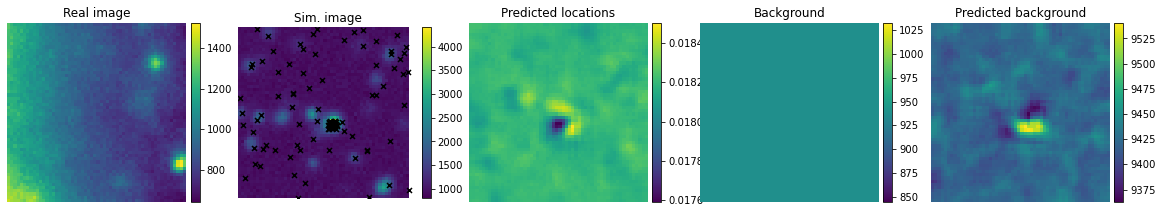

tensor(108320.4453, device='cuda:0', grad_fn=<MulBackward0>) 0.7075980711301048
tensor(168928.6250, device='cuda:0', grad_fn=<MulBackward0>) 0.8367317551206781
tensor(2427.8403, device='cuda:0', grad_fn=<MulBackward0>) 0.11832748684080074
tensor(14909.7783, device='cuda:0', grad_fn=<MulBackward0>) -0.5417531572415919
tensor(7984.1890, device='cuda:0', grad_fn=<MulBackward0>) 0.3013045497046547
tensor(10040.7803, device='cuda:0', grad_fn=<MulBackward0>) -0.09431562720149936
tensor(4476.4355, device='cuda:0', grad_fn=<MulBackward0>) 0.06975335489384256
tensor(5697.7900, device='cuda:0', grad_fn=<MulBackward0>) 0.12434968433221218
tensor(3194.7388, device='cuda:0', grad_fn=<MulBackward0>) 0.21478595431397227
tensor(4258.0039, device='cuda:0', grad_fn=<MulBackward0>) 0.3587300517761209
tensor(4787.7471, device='cuda:0', grad_fn=<MulBackward0>) 0.2682727857188129
tensor(26868.1836, device='cuda:0', grad_fn=<MulBackward0>) 0.5533145433604135
tensor(6125.0332, device='cuda:0', grad_fn=<MulBac

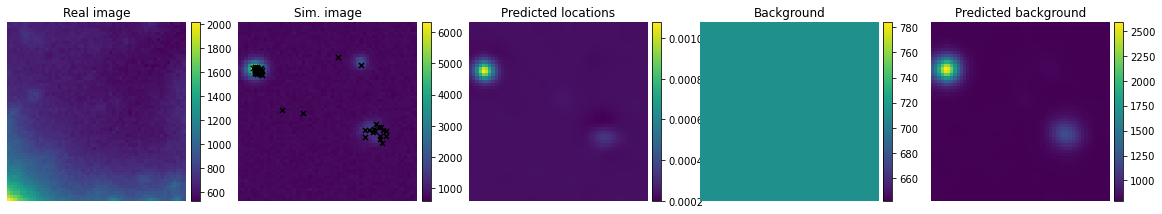

tensor(461.1596, device='cuda:0', grad_fn=<MulBackward0>) 0.9341958876757352
tensor(646.1849, device='cuda:0', grad_fn=<MulBackward0>) 0.839128819621994
tensor(1200.1844, device='cuda:0', grad_fn=<MulBackward0>) 0.8987298649281671
tensor(364.1631, device='cuda:0', grad_fn=<MulBackward0>) 0.8567266367895444
tensor(471.6185, device='cuda:0', grad_fn=<MulBackward0>) 0.9178556802375656
tensor(670.2200, device='cuda:0', grad_fn=<MulBackward0>) 0.6673961320420795
tensor(726.1712, device='cuda:0', grad_fn=<MulBackward0>) 0.8582184380820471
tensor(572.8703, device='cuda:0', grad_fn=<MulBackward0>) 0.8876279028192232
tensor(562.3528, device='cuda:0', grad_fn=<MulBackward0>) 0.8674784961649593
tensor(505.1181, device='cuda:0', grad_fn=<MulBackward0>) 0.939921219017565
tensor(537.8558, device='cuda:0', grad_fn=<MulBackward0>) 0.942373807993877
tensor(575.8036, device='cuda:0', grad_fn=<MulBackward0>) 0.9531635832614728
tensor(403.4207, device='cuda:0', grad_fn=<MulBackward0>) 0.9623503062156759
t

KeyboardInterrupt: 

In [ ]:
train(cfg=cfg,
     model=model, 
     microscope=micro, 
     post_proc=post_proc,
     dl=decode_dl, 
     optim_dict=optim_dict)

In [ ]:
def sim_data(decode_dl, micro, batches, int_conc=4., int_rate=1., int_loc=.5, channels=1, n_bits=1, codebook=None, rate_fac=1., pos_noise_xy=0., pos_noise_z=0., 
             emitter_noise_rate_fac=0, emitter_noise_int_fac=0, const_theta_sim=True, int_option=1):
    
    gt_dfs = []
    xsim_col = []
    cols_col = []

    for _ in range(batches):
        with torch.no_grad():
            ret_dict = next(iter(decode_dl))
            x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'], 
            zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
            background = background * micro.get_ch_mult()
            local_rate *= rate_fac
            
            sim_vars = PointProcessUniform(local_rate[:,0], int_conc, int_rate, int_loc, channels=channels, n_bits=n_bits, sim_z=micro.slice_rec, codebook=codebook, int_option=int_option).sample(from_code_book=(codebook is not None))
            ch_inp = list(micro.get_single_ch_inputs(*sim_vars[:-1], ycrop=ycrop.flatten(), xcrop=xcrop.flatten()))
            if pos_noise_xy or pos_noise_z:
                ch_inp[1:4] = add_pos_noise(ch_inp[1:4], [pos_noise_xy, pos_noise_xy, pos_noise_z], n_bits)
            xsim = micro(*ch_inp, add_noise=True)

            if emitter_noise_rate_fac:
                noise_vars = PointProcessUniform(local_rate[:,0] * emitter_noise_rate_fac, int_conc=int_conc * emitter_noise_int_fac, 
                                               int_rate=int_rate, int_loc=int_loc, 
                                               sim_iters=5, channels=channels, n_bits=1, 
                                               sim_z=micro.slice_rec, codebook=None, int_option=int_option).sample(from_code_book=False)     

                noise_inp = micro.get_single_ch_inputs(*noise_vars[:-1], ycrop=ycrop.flatten(), xcrop=xcrop.flatten())
                xsim += micro(*noise_inp, add_noise=True)
        
            x = micro.noise(xsim, background, const_theta_sim=const_theta_sim).sample()

            if micro.col_shifts_enabled:
                colshift_crop = get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx, ycrop, xcrop, decode_dl.dataset.dataset_tfms[0].crop_sz[-1])
                net_inp = torch.concat([x,colshift_crop], 1)
                cols_col.append(colshift_crop)
                
            xsim_col.append(x)

            gt_vars = sim_vars[:-2] 
            gt_df = sample_to_df(*gt_vars, sim_vars[-1], px_size_zyx=[1.,1.,1.])
            gt_dfs.append(gt_df)
        
    return torch.cat(xsim_col), torch.cat(cols_col), cat_emitter_dfs(gt_dfs, decode_dl.batch_size)

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 02b_place_psfs.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted 24_exp_specific.ipynb.
Converted 25_ensembling.ipynb.
Converted 26_gen_train.ipynb.
Converted 27_testtime_rescale.ipynb.
Converted index.ipynb.
